In [1]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import random

In [2]:
from pl_bolts.models.autoencoders.components import (
    # resnet18_decoder,
    # resnet18_encoder,
    ResNetEncoder,
    ResNetEncoder,
    EncoderBlock,
    DecoderBlock,
    conv1x1,
    resize_conv1x1,
    Interpolate,
)

/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Un

In [3]:
class ResNetEncoder(nn.Module):
    def __init__(self, block, layers, first_conv=False, maxpool1=False) -> None:
        super().__init__()

        self.inplanes = 64
        self.first_conv = first_conv
        self.maxpool1 = maxpool1

        if self.first_conv:
            self.conv1 = nn.Conv2d(4, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = nn.Conv2d(4, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        if self.maxpool1:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return torch.flatten(x, 1)

In [21]:
class ResNetDecoder(nn.Module):
    """Resnet in reverse order."""

    def __init__(self, block, layers, latent_dim, input_height, first_conv=False, maxpool1=False) -> None:
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.first_conv = first_conv
        self.maxpool1 = maxpool1
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)

        if self.maxpool1:
            self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
            self.upscale_factor *= 2
        else:
            self.layer4 = self._make_layer(block, 64, layers[3])

        if self.first_conv:
            self.upscale = Interpolate(scale_factor=2)
            self.upscale_factor *= 2
        else:
            self.upscale = Interpolate(scale_factor=1)

        # interpolate after linear layer using scale factor
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(64 * block.expansion, 3, kernel_size=3, stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)

        return self.conv1(x)


In [22]:
def resnet18_encoder(first_conv, maxpool1):
    return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)


def resnet18_decoder(latent_dim, input_height, first_conv, maxpool1):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)


In [ ]:
# resnet18_encoder(False, False)

In [ ]:
# resnet18_decoder(
#     latent_dim=266,
#     input_height=32, 
#     first_conv=False, 
#     maxpool1=False
# )

In [27]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()
        self.input_height = input_height

        self.label_embed = nn.Embedding(10, embedding_dim=input_height)
        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, label = batch

        label_onehot = nn.functional.one_hot(label, num_classes=10)
        label_embed = self.label_embed(label_onehot).to(self.device).unsqueeze(dim=1)
        # print(label_embed.shape)
        # print(label)
        # print(x.shape)
        self.padder = torch.zeros(x.shape[0], 1, self.input_height-10, self.input_height).to(self.device)
        padded_label_embed = torch.cat([label_embed,self.padder], dim = 2).to(self.device)
        # print('padded label size ', padded_label_embed.shape)
        # x = torch.add(x, padded_label_embed)
        x_with_label = torch.cat([x, padded_label_embed], dim=1)
        # print('final x shape ', x.shape)
        
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x_with_label)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        # z = torch.cat([q.rsample(), label_onehot], dim=1)

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [24]:
from pl_bolts.datamodules import CIFAR10DataModule, MNISTDataModule

datamodule = CIFAR10DataModule('.')
# datamodule = MNISTDataModule('.')

In [ ]:
# torch.cat([torch.rand(1, 256), torch.rand(1, 10)], dim=1)

In [ ]:
# x = torch.rand(1, 28, 28)
# x

In [ ]:
# # y = torch.randint(10, dtype=torch.int64) #, dtype = torch.int32)
# # y = torch.LongTensor([[0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]])
# y = torch.LongTensor([[0,1,0,0,0,0,0,0,0,0]])
# y.shape
# y
# y_embed = nn.Embedding(10, embedding_dim = 28)
# y_embed(y).shape
# # torch.cat((x, y_embed(y)), 2).shape

In [ ]:
# # nn.ConstantPad1d((0, 512 - 49), 0)(y_embed(y))
# padder = torch.zeros(1, 18, 28)
# padder.shape
# padded_a = torch.cat([y_embed(y),padder], dim = 1)
# padded_a
# torch.cat((x, padded_a), 0).shape

In [31]:
# DATA
# we're pretending to have an image from cifar-10 + Label (4 channels, 32x32 pixels)
vae_tmp = VAE(input_height=32)
x = torch.rand(1,4, 32, 32)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae_tmp.encoder(x)
mu, log_var = vae_tmp.fc_mu(x_encoded), vae_tmp.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

image shape: torch.Size([1, 4, 32, 32])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


/tmp/ipykernel_11153/2526237549.py:37: UnderReviewWarning: The feature EncoderBlock is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  layers.append(block(self.inplanes, planes, stride, downsample))
/tmp/ipykernel_11153/2526237549.py:32: UnderReviewWarning: The feature conv1x1 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  conv1x1(self.inplanes, planes * block.expansion, stride),
/tmp/ipykernel_11153/799789410.py:42: UnderReviewWarning: The feature resize_conv1x1 is currently marked under review. The compatibility with oth

In [28]:
pl.seed_everything(1234)

vae = VAE(input_height=32)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=20) # progress_bar_refresh_rate=10)
trainer.fit(vae, datamodule=datamodule)

Global seed set to 1234
/tmp/ipykernel_11153/2526237549.py:37: UnderReviewWarning: The feature EncoderBlock is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  layers.append(block(self.inplanes, planes, stride, downsample))
/tmp/ipykernel_11153/2526237549.py:32: UnderReviewWarning: The feature conv1x1 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  conv1x1(self.inplanes, planes * block.expansion, stride),
/tmp/ipykernel_11153/799789410.py:42: UnderReviewWarning: The feature resize_conv1x1 is currently marked under review. Th

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type          | Params
----------------------------------------------
0 | label_embed | Embedding     | 320   
1 | encoder     | ResNetEncoder | 11.2 M
2 | decoder     | ResNetDecoder | 8.6 M 
3 | fc_mu       | Linear        | 131 K 
4 | fc_var      | Linear        | 131 K 
----------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.232    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


torch.Size([25, 3, 32, 32])


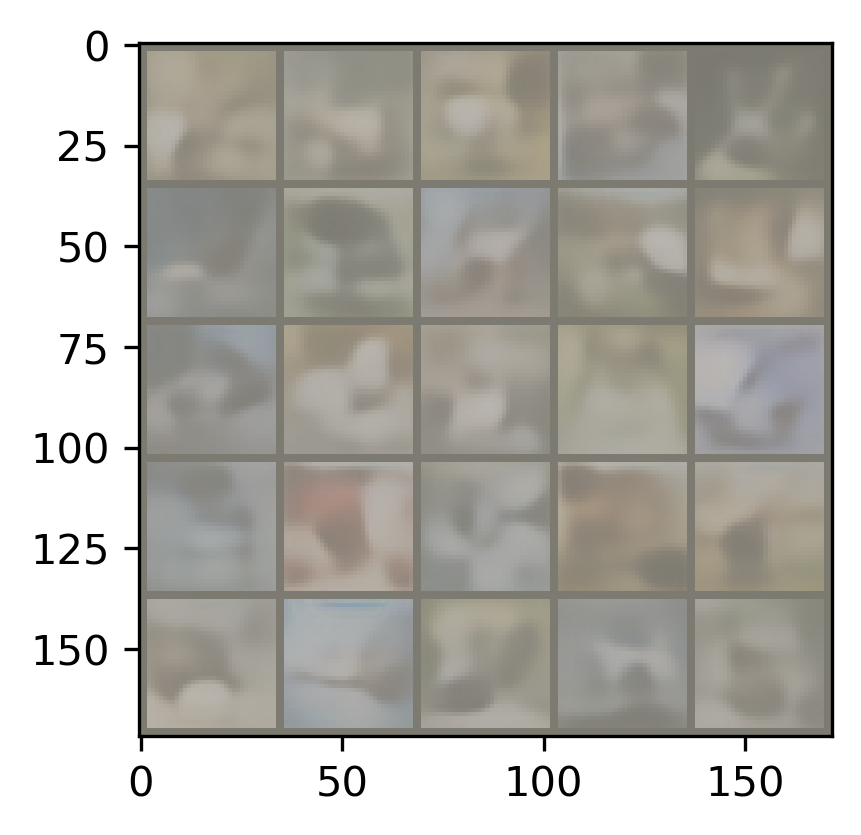

In [32]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 25
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

print(pred.shape)
# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred, 5).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);

In [34]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14461), started 0:01:54 ago. (Use '!kill 14461' to kill it.)

## Plot result of image with wrong label as input

In [50]:
from dataset import train_loader, test_loader

In [90]:
def get_wrong_label(label_list):
    new_list = []
    for n in label_list:
        list_10 = list(range(10))
        list_10.pop(n)
        new_list.append(random.choice(list_10))
    return new_list

In [86]:
# get  a random batch of 512 images
new_batch = next(iter(train_loader))

In [87]:
# pick the first 25 images and their label for input
val_batch = [new_batch[0][:25], new_batch[1][:25]]

In [88]:
val_batch

[tensor([[[[ 4.2752e-02,  1.1003e-02,  4.2752e-02,  ...,  7.4124e-01,
             5.8249e-01,  1.2175e+00],
           [ 4.7137e-01,  5.3487e-01,  5.6662e-01,  ...,  9.9524e-01,
             1.0270e+00,  1.4556e+00],
           [ 4.2752e-02,  1.1003e-02,  4.2752e-02,  ...,  7.4124e-01,
             5.8249e-01,  1.2175e+00],
           ...,
           [ 1.9318e+00,  1.8525e+00,  1.8207e+00,  ..., -1.4495e+00,
            -1.1955e+00, -1.1320e+00],
           [ 1.9001e+00,  1.8525e+00,  1.9318e+00,  ..., -1.4653e+00,
            -1.1637e+00, -1.1161e+00],
           [ 1.9001e+00,  1.9001e+00,  1.9477e+00,  ..., -1.4336e+00,
            -1.1479e+00, -1.1796e+00]],
 
          [[ 4.3566e-01,  4.3566e-01,  4.6787e-01,  ...,  4.6787e-01,
             8.8663e-01,  1.0799e+00],
           [ 7.7389e-01,  8.5442e-01,  8.8663e-01,  ...,  3.7124e-01,
             1.3054e+00,  1.4020e+00],
           [ 4.3566e-01,  4.3566e-01,  4.6787e-01,  ...,  4.6787e-01,
             8.8663e-01,  1.0799e+00],


In [96]:
x_val, label_true = val_batch

label_val =  torch.tensor(get_wrong_label(label_true.tolist()))
label_val, label_true

(tensor([3, 7, 9, 8, 5, 3, 2, 0, 2, 3, 9, 1, 6, 2, 0, 0, 1, 2, 3, 0, 7, 7, 6, 4,
         6]),
 tensor([1, 8, 5, 0, 9, 1, 7, 5, 8, 0, 7, 3, 3, 4, 5, 3, 3, 4, 6, 8, 1, 0, 5, 3,
         8]))

In [97]:
x_val.shape

torch.Size([25, 3, 32, 32])

torch.Size([25, 3, 32, 32])


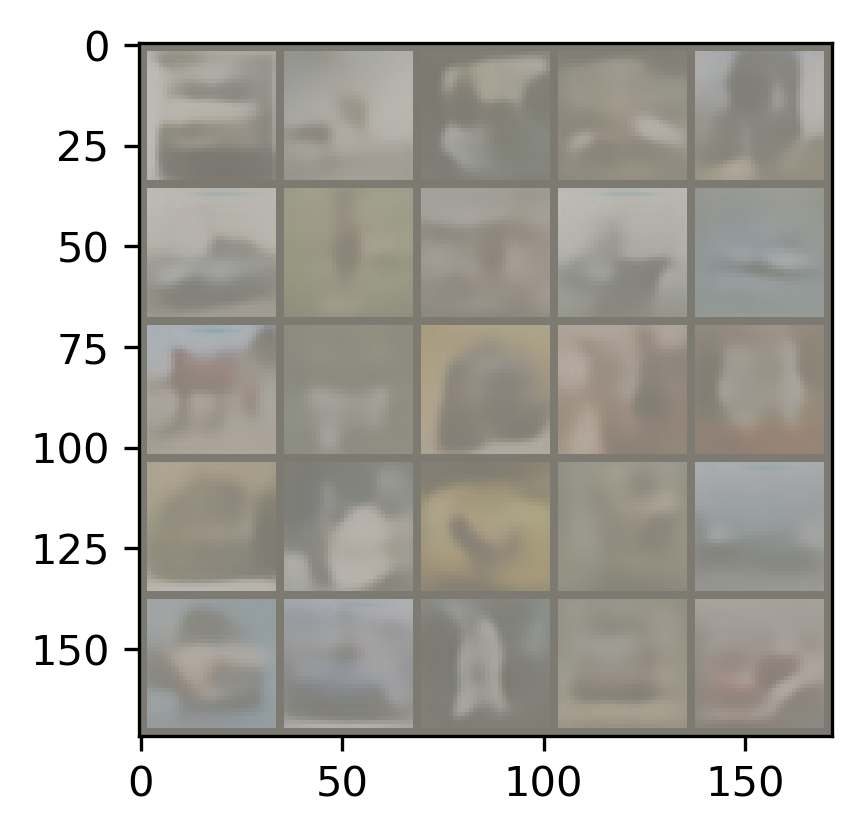

In [99]:
figure(figsize=(8, 3), dpi=300)
label_onehot = nn.functional.one_hot(label_val, num_classes=10)
label_embed = vae.label_embed(label_onehot).to(vae.device).unsqueeze(dim=1)
val_padder = torch.zeros(x_val.shape[0], 1, vae.input_height-10, vae.input_height).to(vae.device)
padded_label_embed = torch.cat([label_embed,val_padder], dim = 2).to(vae.device)
x_val_with_label = torch.cat([x_val, padded_label_embed], dim=1)
# print('final x shape ', x.shape)

# encode x to get the mu and variance parameters
with torch.no_grad():
    x_val_encoded = vae.encoder(x_val_with_label)
mu, log_var = vae.fc_mu(x_val_encoded), vae.fc_var(x_val_encoded)

# sample z from q
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()
# z = torch.cat([q.rsample(), label_onehot], dim=1)

# decoded 
with torch.no_grad():
    pred_val = vae.decoder(z.to(vae.device)).cpu()

print(pred_val.shape)
# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred_val, 5).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);